# Extra: Basics of Bayesian Inference

**WORK IN PROGRESS**

An important aspect to understand in MCMC, more specifically the Metropolis-Hastings sampler, is how the variance for the proposal distribution affects both the acceptance ratio and the correlation between samples. 

First a simple example will be used to show how the likelihood and prior combine into the posterior. 
The second example aims to explain the impact of proposal distribution standard deviation on the sample acceptance ratio. 
Lastly, the negative impact of the proposal distribution standard deviation on the correlation between MCMC samples is shown.

## 1. Combination of prior and likelihood into the posterior: 2 sources of information

In [11]:
# Import required packages.
# - Plot figures inline with text in this notebook.
%matplotlib inline
# - Higher DPI figures.
%config InlineBackend.figure_format='retina'
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import Source.BayesianInferenceFunctions as BiF  # Bayesian inference.

Here are the input settings to a small example of a 2-dimensional MCMC problem. Both the likelihood and prior PDF have several inputs.

First, for the likelihood aspect: the measurement data.
Only a single data-point is available of the system we're measuring, e.g. $d=1$. Every measurement has a certain measurement error, either known through multiple measurements or estimated from expectations, or used as a tuning parameter for the fit.

In [12]:
# - Measurements, related to the likelihood.
D = 1  # Measurement of the system state, d = u + epsilon (measurement = the true system state + measurement error).
D_SD = 0.08  # Measurement error SD. 

Second, for the prior: the expected parameter values.
A PDF needs to be defined, capturing all parameters. This PDF can be anything, most importantly it reflects our knowledge of the parameters. The least amount of knowledge can be reflected by a uniform distribution delimiting the physically plausible range of the parameter. If the most probable parameter value is known, a normal distribution can be defined centred on that most probable set of parameter values. Here the mean and standard deviation of the Gaussian are defined.

In [13]:
# - Prior PDF, related to the prior.
PRIOR_MU = np.array([0.2, 0.4])  # Prior mean.
PRIOR_SD = np.array([0.05, 0.05])  # Prior SD.
# Define the object of the prior, used later.
normal_prior = stats.norm(loc=PRIOR_MU, scale=PRIOR_SD)  # Prior PDF.

The model is a very simple linear model: $$ u_i = m(\theta_i) = \theta_i|_0 + \theta_i|_1 $$
This model can be based on theoretical knowledge of the system or many observations of the system resulting in our guess of the system, this model can be iteratively improved using Bayesian inference. 

Here we know that the system is affected by two parameters, and that the output of the system is simply the sum of both. The posterior PDF calls this model and the prior PDF object made before.

In [14]:
def model(theta_i):
    # m(theta_i) = theta_i[0] + theta_i[1]
    return sum(theta_i[:2])


def posterior(theta_i):
    # Logarithmic (!) PDF of the posterior
    u_i = model(theta_i=theta_i)  # u_i = m(theta_p)
    like_i = BiF.likelihood_log_pdf(u=u_i, d=D, sigma_d=D_SD)  # Likelihood 
    prior_i = np.sum(normal_prior.logpdf(x=theta_i))  # Prior
    return like_i+prior_i

In the following code cell, all PDFs are computed on a grid of points used for visualisation. This is not the MCMC method, this is simply for the contours of the PDFs, used to show what the MCMC needs to find (mostly the posterior).

In [15]:
# Define grid on which PDFs are computed.
NX, NY = 3000, 3000  # Number of points in x and y.
# Limits of the x- and y-axes.
X_LIM = (0, 1)
Y_LIM = (0, 1)
# ----------------------
# x- and y-array of the grid.
x_arr = np.linspace(X_LIM[0], X_LIM[1], NX)
y_arr = np.linspace(Y_LIM[0], Y_LIM[1], NY)
xx, yy = np.meshgrid(x_arr, y_arr)  # Combine these in a grid.
xxyy = np.concatenate((xx[np.newaxis], yy[np.newaxis]), axis=0)
# ----------------------
# Compute the prior PDF on the grid.
prior_mu = np.tile(PRIOR_MU[:, np.newaxis, np.newaxis], (1, NY, NX))
prior_sd = np.tile(PRIOR_SD[:, np.newaxis, np.newaxis], (1, NY, NX))
prior_grid = stats.norm(loc=prior_mu, scale=prior_sd)
prior_pdf = np.sum(prior_grid.logpdf(x=xxyy), axis=0)
# ----------------------
# Compute this very simple likelihood on the grid.
d_hu_arr = D - np.sum(xxyy, axis=0)
like_pdf = stats.norm(loc=0, scale=D_SD).logpdf(x=d_hu_arr)
# ----------------------
# Combined to form the posterior PDF.
post_pdf = like_pdf + prior_pdf

This is the MCMC code cell. Several inputs are needed: the number of MCMC samples, the covariance matrix for the proposal distribution, and the initial guess.

In [16]:
# Inputs.
N_SAMPLES = 500
THETA_0 = np.array([0.9, 0.9])
SIGMA_P = 1E-1

# MCMC run.
chain, p_arr, seed_dct = BiF.mcmc_update(n_params=2, posterior_log_pdf=posterior, theta_0=THETA_0, n_samples=N_SAMPLES, sigma_p=SIGMA_P, n_updates=N_SAMPLES//10, seed=3751)
THETA_OPT = chain[np.argmax(p_arr), :]  # Best guess parameters.

(1/10) Acceptance Ratio: 34.69%
(2/10) Acceptance Ratio: 38.78%
(3/10) Acceptance Ratio: 16.33%
(4/10) Acceptance Ratio: 20.41%
(5/10) Acceptance Ratio: 26.53%
(6/10) Acceptance Ratio: 26.53%
(7/10) Acceptance Ratio: 26.53%
(8/10) Acceptance Ratio: 18.37%
(9/10) Acceptance Ratio: 24.49%
Acceptance Ratio: 25.85%


Both the previously computed PDF contours and the MCMC chain are shown.

C:\Users\Olivier\AppData\Local\Temp\ipykernel_15776\3096637867.py:54: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout(pad=0.1)


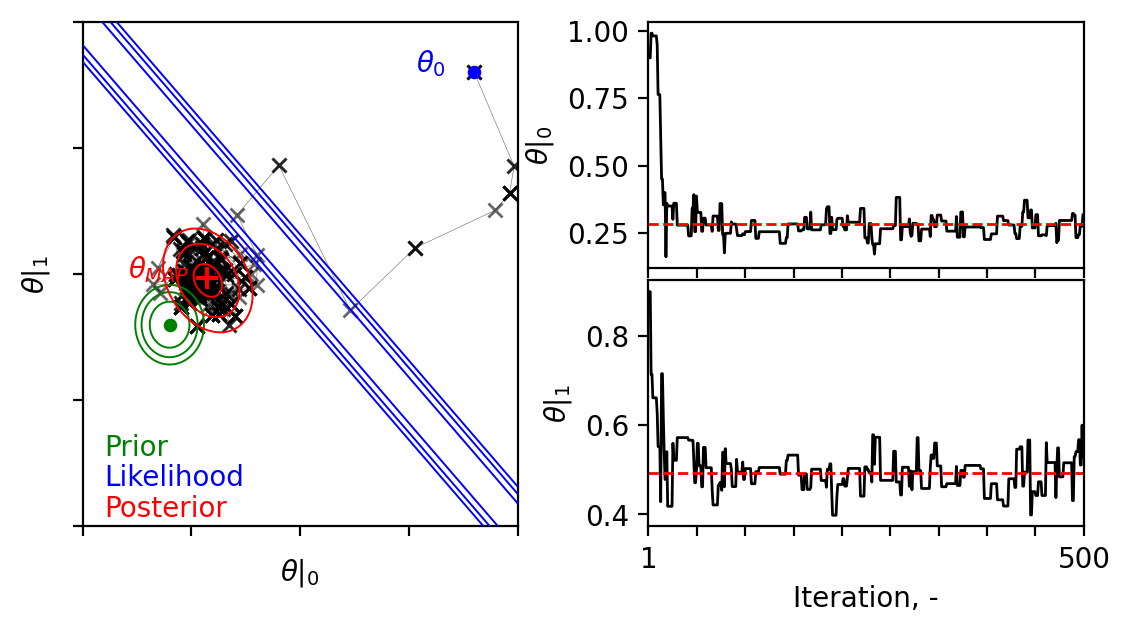

In [17]:
fig, ax = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              figsize=(5.5, 3.), layout="constrained")

HDI_LEVELS = (0.68, 0.95, 0.99)

# Chain of MCMC samples.
ax['left'].plot(chain[:, 0], chain[:, 1], color='k', linewidth=0.2, marker='x', markersize=5, alpha=0.6)
# Prior PDF.
ax['left'].contour(xx, yy, prior_pdf, linewidths=0.7, linestyles='-', colors='g', zorder=4,
           levels=np.max(prior_pdf)*np.array([0.7, 0.8, 0.9]))
# Likelihood PDF.
ax['left'].contour(xx, yy, like_pdf, linewidths=0.7, linestyles='-', colors='b', zorder=4,
           levels=np.max(like_pdf)*np.array([0.7, 0.8, 0.9]))
# Posterior PDF.
ax['left'].contour(xx, yy, post_pdf, linewidths=0.7, linestyles='-', colors='r', zorder=4,
           levels=(np.max(post_pdf)-np.min(post_pdf))*np.array([0.99, 0.995, 0.999])+np.min(post_pdf))

ax['left'].scatter(*THETA_OPT.T, color='r', marker='+', s=60, zorder=5)  # Optimal guess parameters.
ax['left'].scatter(*THETA_0.T, color='b', marker='.', s=60, zorder=5)  # Initial guess parameters.
ax['left'].scatter(*PRIOR_MU.T, color='g', marker='.', s=60, zorder=5)  # Prior mean.

# Parameter evolution, per iteration.
n_samples = chain[:, 0].size
chain_iter = np.arange(1, n_samples+1)
ax['upper right'].plot(chain_iter, chain[:, 0], color='k', linewidth=1)
ax['lower right'].plot(chain_iter, chain[:, 1], color='k', linewidth=1)

# Text in the figure.
ax['left'].annotate(r'$\theta_0$    ', xy=THETA_0, ha='right', xycoords='data', color='b')
ax['left'].annotate(r'$\theta_{MAP}$   ', xy=THETA_OPT, ha='right', xycoords='data', color='r')
ax['left'].annotate('Prior', xy=(0.05, 0.14), ha='left', xycoords='data', color='g')
ax['left'].annotate('Likelihood', xy=(0.05, 0.08), ha='left', xycoords='data', color='b')
ax['left'].annotate('Posterior', xy=(0.05, 0.02), ha='left', xycoords='data', color='r')

# Styling of the figure.
ax['left'].set_xticks(ticks=[0., 0.25, 0.5, 0.75, 1.], labels=['', '', '', '', ''])
ax['left'].set_yticks(ticks=[0., 0.25, 0.5, 0.75, 1.], labels=['', '', '', '', ''])
ax['left'].set_xlabel(r'$\theta|_0$')
ax['left'].set_ylabel(r'$\theta|_1$')
ax['left'].set_xlim(*X_LIM)
ax['left'].set_ylim(*Y_LIM)
ax['upper right'].set_ylabel(r'$\theta|_0$')
ax['lower right'].set_ylabel(r'$\theta|_1$')
ax['lower right'].set_xlabel('Iteration, -')
x_range = np.linspace(1, n_samples, 10)
ax['lower right'].set_xticks(ticks=x_range, labels=['1']+(len(x_range)-2)*['']+[str(n_samples)])
ax['upper right'].set_xticks(ticks=x_range, labels=len(x_range)*[''])
ax['left'].set_yticks(ticks=[0., 0.25, 0.5, 0.75, 1.], labels=['', '', '', '', ''])
ax['upper right'].set_xlim(1, n_samples)
ax['lower right'].set_xlim(1, n_samples)
ax['upper right'].axhline(THETA_OPT[0], color='r', linewidth=1., linestyle='--')
ax['lower right'].axhline(THETA_OPT[1], color='r', linewidth=1., linestyle='--')
fig.tight_layout(pad=0.1)
fig.subplots_adjust(wspace=0.3)

### Likelihood + Prior = Posterior
Due to the nature of the model, there is an entire line of possible parameter combinations that result in $d=1$. Due to the possible measurement error, the exact parameter solution is also allowed to deviate slightly. The prior PDF picks a single probable value from the range of probable parameters defined by the likelihood. This is how these sources of information combine into the posterior. If you go back and tweak either the measurement error variance or the prior variances, the posterior will be pulled closer to either the likelihood or prior. 

### MCMC chain
Starting from the initial guess, many samples are required to reach the region of high probability. The further the initial guess, the more wasted samples. Once the high-probability region is reached enough samples are required to have the distribution of samples properly represent the posterior PDF. If done properly, you can see that the highest concentration of samples is situated around the MAP, and the density of samples feathers out away from the MAP. 

## 2. Effect of proposal distribution standard deviation on the acceptance ratio
Feel free to go back to the prior example of the MCMC and increase or decrease the proposal distribution standard deviation (SD). Increasing the SD, increases the step-size between samples, which decreases the acceptance ratio, and vice versa.

### Example 1: 1-D posterior
The following example uses a 1-D Gaussian posterior $p(\theta|d)$. The central red point indicates the current MCMC sample $\theta_{i-1}$, with the x-axis the range of possible proposal samples $\theta_p$.
The proposal distribution SD $\sigma_p$ (**SD_G**) should be played with below:

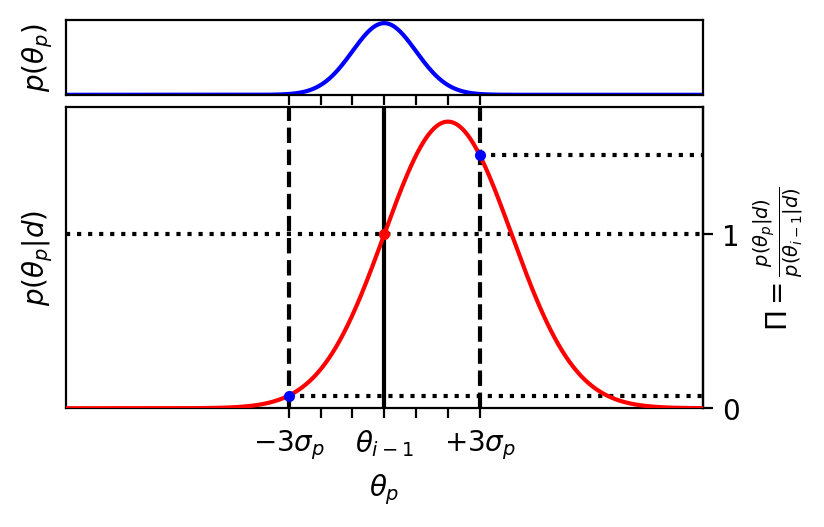

In [18]:
SD_G = 0.05  # Sample proposal standard deviation.

# ---------------------------
THETA_CURRENT = 0.5  # Current (last accepted) parameter sample.
post_norm = stats.norm(loc=0.6, scale=0.1)  # Posterior PDF.

theta_p_min, theta_p_max = THETA_CURRENT - 3*SD_G, THETA_CURRENT + 3*SD_G  # 3*SD range of sample Gaussian proposal distribution around current sample.
x_min, x_max = min(0, theta_p_min), max(1, theta_p_max)  # Extrema for plotting.
theta_p_arr = np.linspace(x_min, x_max, 1001)  # Range of proposal parameter samples.
post_pdf2 = post_norm.pdf(x=theta_p_arr)  # Posterior PDF for all the full range of proposal parameter values.
post_current, post_p_min, post_p_max = post_norm.pdf(x=np.array([THETA_CURRENT, theta_p_min, theta_p_max]))  # The posterior PDF for the current sample, and at 3*SD_p from the current sample.

# Plotting.
fig, ax = plt.subplots(2, 1, figsize=(4, 2.5), sharex='col', gridspec_kw={'height_ratios': [1, 4]})
ax[0].plot(theta_p_arr, stats.norm(loc=THETA_CURRENT, scale=SD_G).pdf(x=theta_p_arr), color='b')  # Gaussian of the proposal sample distribution, g_i~N(0, P), theta_p = theta_{i-1}+g_i.
ax[1].plot(theta_p_arr, post_pdf2, color='r', zorder=4)  # Posterior PDF for full range of theta_p.
ax[1].axvline(THETA_CURRENT, color='k', linestyle='-')  # Current sample.
ax[1].axvline(theta_p_min, color='k', linestyle='--')  # Current sample - 3*SD_p
ax[1].axvline(theta_p_max, color='k', linestyle='--')  # Current sample + 3*SD_p
ax[1].axhline(post_current, color='k', linestyle=':') # Pi = 1. y_i ~ U(0, 1) and samples are accepted if Pi > y_i. theta_p with Pi > 1 are guaranteed to be accepted, Pi < 1 have a decreasing probability of being accepted. 
ax[1].plot([theta_p_min, X_LIM[1]], [post_p_min]*2, color='k', linestyle=':')  # Pi(theta_{i-1} - 3*SD)
ax[1].plot([theta_p_max, X_LIM[1]], [post_p_max]*2, color='k', linestyle=':')  # Pi(theta_{i-1} + 3*SD)
ax[1].scatter([THETA_CURRENT], [post_current], color='r', marker='.', zorder=5)
ax[1].scatter([theta_p_min, theta_p_max], [post_p_min, post_p_max], color='b', marker='.', zorder=5)
ax[1].set_xlabel(r'$\theta_p$')
secay = ax[1].secondary_yaxis('right', functions=(lambda y: y/post_current, lambda y: y*post_current))
secay.set_ylabel(r'$\Pi=\frac{p(\theta_p|d)}{p(\theta_{i-1}|d)}$')
ax[1].set_ylabel(r'$p(\theta_p|d)$')
ax[1].set_xticks(ticks=np.arange(-3, 4, 1)*SD_G+THETA_CURRENT, labels=[r'$-3\sigma_p$', '', '', r'$\theta_{i-1}$', '', '', r'$+3\sigma_p$'])
ax[1].set_yticks([], [])
secay.set_yticks([0, 1], [0, 1])
ax[0].set_ylabel(r'$p(\theta_p)$')
ax[0].set_yticks([], [])
for i in range(2):
    ax[i].set_ylim(0, None)
ax[1].set_xlim(x_min, x_max)
fig.tight_layout(pad=0.1)

Shown above in blue is the Gaussian proposal distribution, centered on the current MCMC sample (the red dot). It shows the probability of the proposed sample $\sigma_p$. In red is the posterior PDF, the vertical lines show the three SD range of the Gaussian proposal distribution, within which the proposal sample is most likely to land. The acceptance criterion for MCMC is: $$ \Pi=\frac{p(\theta_p|d)}{p(\theta_{i-1}|d)} > y_i \sim U(0, 1). $$
So $y_i$ is the sieve, derived from a uniform distribution between 0 and 1. Therefore, any new sample with $\Pi>1$ will always be accepted, while samples with $\Pi<1$ are not guaranteed to be accepted. Therefore, the probability of a sample being accepted decreases with a decreasing $\Pi$. The larger the region of $\Pi<1$ in the $3 \cdot \sigma_p$ range the more likely that the next proposed sample will be rejected. By decreasing $\sigma_p$, you will see that the range of $\Pi$ will be pulled closer to unity, hence increasing the probability of acceptance, hence acceptance rate. 

### Example 2: 2-D posterior
The acceptance rate decreases with the increasing dimension of the parameter vector, which can somewhat be understood from the visualisation below. The overlap between the $\Pi>1$ region and the $3 \cdot \sigma_p$ region decreases with more dimensions.

Below a 2-D Gaussian posterior and two $3 \cdot \sigma_p$ ranges are shown. 

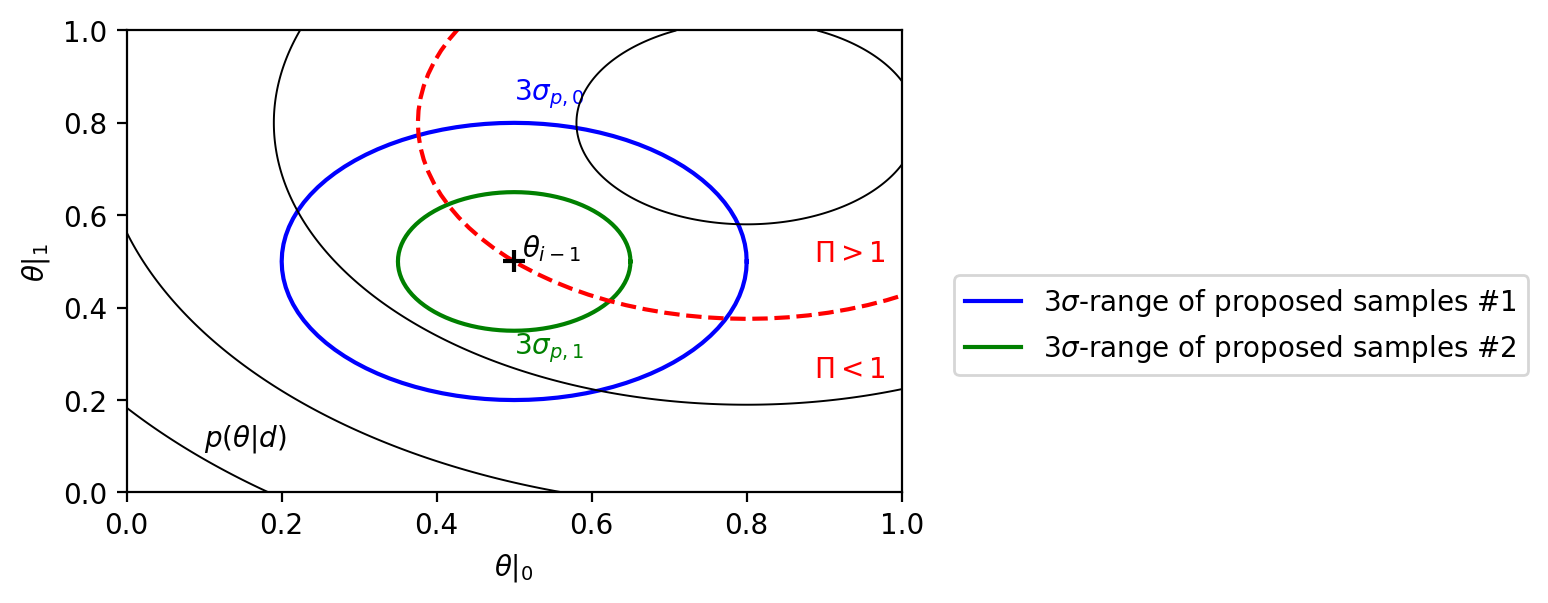

In [19]:
SD_G_0 = 0.1
SD_G_1 = 0.05
# ----------------------
CURRENT = np.array([0.5, 0.5])
POST_MU = np.array([0.8, 0.8])  # Posterior mean.
POST_SD = np.array([0.09, 0.09])  # Posterior SD.

NX, NY = 3000, 3000
X_LIM = (0, 1)
Y_LIM = (0, 1)
# ----------------------
x_arr = np.linspace(X_LIM[0], X_LIM[1], NX)
y_arr = np.linspace(Y_LIM[0], Y_LIM[1], NY)
xx, yy = np.meshgrid(x_arr, y_arr)
xxyy = np.concatenate((xx[np.newaxis], yy[np.newaxis]), axis=0)
# ----------------------
post_mu = np.tile(POST_MU[:, np.newaxis, np.newaxis], (1, NY, NX))
post_sd = np.tile(POST_SD[:, np.newaxis, np.newaxis], (1, NY, NX))

post_grid = stats.norm(loc=post_mu, scale=post_sd)
post_pdf1 = np.sum(post_grid.logpdf(x=xxyy), axis=0)

f_circ = lambda r_i, theta_i, base_x=0., base_y=0.: np.concatenate((r_i*np.cos(theta_i[np.newaxis])+base_x, r_i*np.sin(theta_i[np.newaxis])+base_y), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.contour(xx, yy, post_pdf1, linewidths=0.7, linestyles='-', colors='k', zorder=4, levels=4)
ax.scatter(*CURRENT.T, color='k', marker='+', s=60, zorder=5)
ax.plot(*f_circ(r_i=3*SD_G_0, theta_i=np.linspace(0, 2*np.pi, 101), base_x=CURRENT[0], base_y=CURRENT[1]), color='b', linestyle='-', label=r'$3\sigma$-range of proposed samples #1')
ax.plot(*f_circ(r_i=3*SD_G_1, theta_i=np.linspace(0, 2*np.pi, 101), base_x=CURRENT[0], base_y=CURRENT[1]), color='g', linestyle='-', label=r'$3\sigma$-range of proposed samples #2')
ds = np.abs(CURRENT - POST_MU)
ax.plot(*f_circ(r_i=(ds[0]**2+ds[1]**2)**0.5, theta_i=np.linspace(0, 2*np.pi, 101), base_x=POST_MU[0], base_y=POST_MU[1]), color='r', linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel(r'$\theta|_0$')
ax.set_ylabel(r'$\theta|_1$')
ax.annotate(r'$\theta_{i-1}$', xy=(CURRENT[0]+0.01, CURRENT[1]+0.01), ha='left', xycoords='data', color='k')
ax.annotate(r'$\Pi<1$', xy=(0.98, 0.25), ha='right', xycoords='data', color='r')
ax.annotate(r'$\Pi>1$', xy=(0.98, 0.5), ha='right', xycoords='data', color='r')
ax.annotate(r'$3\sigma_{p, 0}$', xy=(CURRENT[0], CURRENT[1]+3*SD_G_0+0.05), xycoords='data', color='b')
ax.annotate(r'$3\sigma_{p, 1}$', xy=(CURRENT[0], CURRENT[1]-3*SD_G_1-0.05), xycoords='data', color='g')
ax.annotate(r'$p(\theta|d)$', xy=(0.1, 0.1), xycoords='axes fraction', color='k')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 0.5))

## 3. Effect of proposal distribution standard deviation on the correlation between samples

Work in progress

(1.0/10.0) Acceptance Ratio: 29.71%
(2.0/10.0) Acceptance Ratio: 30.05%
(3.0/10.0) Acceptance Ratio: 29.57%
(4.0/10.0) Acceptance Ratio: 29.25%
(5.0/10.0) Acceptance Ratio: 30.43%
(6.0/10.0) Acceptance Ratio: 28.53%
(7.0/10.0) Acceptance Ratio: 30.07%
(8.0/10.0) Acceptance Ratio: 29.51%
(9.0/10.0) Acceptance Ratio: 30.11%
Acceptance Ratio: 29.57%
(1.0/10.0) Acceptance Ratio: 85.26%
(2.0/10.0) Acceptance Ratio: 85.78%
(3.0/10.0) Acceptance Ratio: 83.38%
(4.0/10.0) Acceptance Ratio: 84.58%
(5.0/10.0) Acceptance Ratio: 84.36%
(6.0/10.0) Acceptance Ratio: 84.66%
(7.0/10.0) Acceptance Ratio: 84.88%
(8.0/10.0) Acceptance Ratio: 85.82%
(9.0/10.0) Acceptance Ratio: 84.44%
Acceptance Ratio: 84.71%


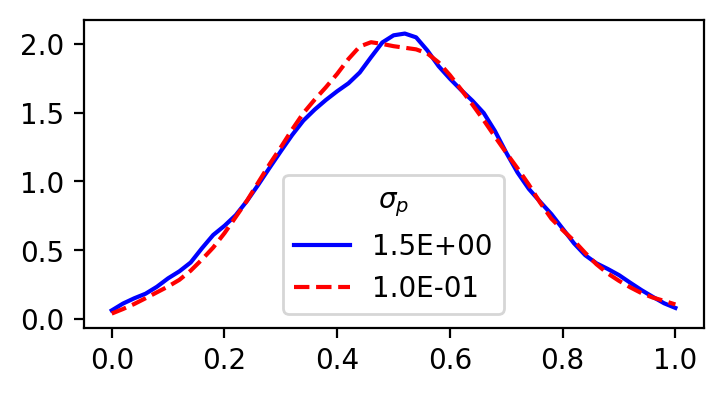

In [20]:
post_pdf3 = stats.norm(loc=0.5, scale=0.2)
f_post_pdf = lambda theta_p_i: post_pdf3.logpdf(x=theta_p_i)

SIGMA_P0 = 1.5E0
SIGMA_P1 = 1E-1
N_SAMPLES = 5E4
# MCMC run.
chain0, p_arr0, seed_dct0 = BiF.mcmc_update(n_params=1, posterior_log_pdf=f_post_pdf, theta_0=np.array([0.]), n_samples=int(N_SAMPLES), sigma_p=SIGMA_P0, n_updates=N_SAMPLES//10, seed=3751)
chain1, p_arr1, seed_dct1 = BiF.mcmc_update(n_params=1, posterior_log_pdf=f_post_pdf, theta_0=np.array([0.]), n_samples=int(N_SAMPLES), sigma_p=SIGMA_P1, n_updates=N_SAMPLES//10, seed=3751)

x = np.linspace(0, 1, 51)
density0 = stats.gaussian_kde(chain0.flatten())  # , bw_method=1.0)
density1 = stats.gaussian_kde(chain1.flatten())
y0 = density0.pdf(x)
y1 = density1.pdf(x)
y = post_pdf3.pdf(x)


fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(x, y0, color='b', linestyle='-', label=f'{SIGMA_P0:.1E}')
ax.plot(x, y1, color='r', linestyle='--', label=f'{SIGMA_P1:.1E}')
ax.legend(title=r'$\sigma_p$')
plt.show()